In [7]:
import numpy as np
import torch
import pickle
import sys
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

# distances
from scipy.spatial.distance import directed_hausdorff
from torch.nn.functional import normalize

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
prior_min = [.5,1e-4,1e-4,1e-4,50,40,1e-4,35]
prior_max = [80.,15.,0.6,0.6,3000,90,0.15,100]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Simulator

In [22]:
from HH_Full_Simulator import syn_current, calculate_summary_statistics

I, t_on, t_off, dt, t, A_soma = syn_current()

In [23]:
from HH_Full_Simulator import HHsimulator

In [24]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [25]:
params_base = [[50., 1.],[4., 1.5],[20., 15.]]
params_additional = [0.1,0.07,6e2,-60.,-.1,-70.0]
params = np.array([params_var + params_additional for params_var in params_base])

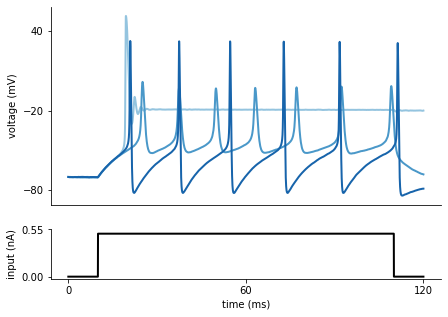

In [26]:
# three sets of (g_Na, g_K)
num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i,:] = run_HH_model(params=params[i,:])['data']

# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

In [37]:
def summ_simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [43]:
def full_simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = torch.tensor(run_HH_model(params)['data'])
    return obs

## Distances

In [51]:
def hausdorff_dist(x,y, reverse = False):
    x_pairs = np.array([x['time'],x['data']]).T
    y_pairs = np.array([y['time'],y['data']]).T
    if reverse:
        return directed_hausdorff(y_pairs,x_pairs)
    return directed_hausdorff(x_pairs,y_pairs)
    # x_pairs = torch.vstack([x['time'],x['data']])


## Simulator

In [71]:
true_params = prior.sample()
observation_trace = run_HH_model(true_params)

simulator,prior = prepare_for_sbi(full_simulation_wrapper,prior)
theta, data = simulate_for_sbi(simulator, prior, num_simulations=100, num_workers=7)

data_np = data.detach().numpy()

time = observation_trace['time']

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [65]:
def get_hausdorff_scores(data):

    def hausdorff_score(params):
        input = run_HH_model(params)
        distances = []
        for array in data:
            aug_data = {'time':time, 'data':array}
            distances.append(torch.tensor(hausdorff_dist(input,aug_data)[0]))
        return torch.tensor(distances)
    
    return hausdorff_score


In [73]:
score_function = get_hausdorff_scores(data_np)

In [74]:
score_function(true_params)

tensor([58.8732, 18.9730, 24.2478, 38.9298, 20.2724, 14.6334, 10.4894, 34.7582,
        58.7106, 46.4646, 34.2014, 34.6258, 45.0832, 43.0522, 47.6703, 55.2017,
         3.6280, 53.2980, 18.9814, 12.1240, 34.5748, 38.6682, 17.6346, 14.2765,
        21.9060, 20.5037, 25.1005, 11.3516, 30.8260, 24.2595, 11.7493, 17.9380,
        30.1122, 24.2822, 12.4978, 23.5575, 14.3713, 37.6761, 30.8201, 10.7265,
         5.9533, 38.4313,  8.9119, 42.2061, 39.8082, 49.1134,  8.5959, 21.1462,
        26.5335, 31.4774, 40.2522, 13.3532, 20.7274, 25.4208, 15.2624, 18.9576,
        14.4734, 29.3089, 76.6153, 18.6067, 45.2089, 28.6457, 48.1857, 21.5819,
        41.9539, 67.6256, 15.4138, 19.3772, 28.7400, 35.6331, 28.4573, 12.8577,
        15.8422, 46.4274, 45.0672, 10.8402, 41.7726, 31.2217, 35.8417, 20.6506,
        17.5580, 29.6936,  5.3929, 37.6173, 30.9985, 35.4184, 26.1391, 15.8462,
        29.0673, 17.2280, 35.0097, 19.1030, 25.5807, 20.4610,  7.5082, 23.4060,
        43.2368, 26.1429, 34.4436, 35.74